In [1]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import requests

from scraper.headers import HEADERS

In [2]:
import scipy
from scipy.stats import geom
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis overview

The analysis will be done as a statistical simulation using the empirical election transmissions (ER) data received by the COMELEC's transparency servers.

The primary question that we want to probe is whether the seemingly constant temporal disparity between Bongbong Marcos' vs. Leni Robredo's rate of votes is a statistical anomaly. Conclusion whether cheating at any level or of any form is not covered by this analysis.

With the availability of the ER data that can be scraped from the transparency servers, we can perform statistical simulations on the actual vote counts data. The analysis will rely on some statistical assumptions:

1. That success of the transmission of a single return is independent of other transmissions.
2. The probability of success of transmission is uniform across precincts.
    - We can check the distribution of the votes for each polling precinct to see how might we improve the assumption.
    - This can be further refined and can be modeled using a more sophisticated distribution as we build better understanding of other underlying factors that affect the transmission.

The two assumptions will be embedded in the simulation as a Geometric distribution modeling the transmission time of each precinct after the closing of the polls.

We shall build an ensemble of simulations and calculate the expected rate of votes difference between the two candidates. Using the data of the simulation, we can then compare the empirical values of the rate of votes and see if this lies within the statistical confidence interval of the modeled process.

# Set up data requirements

In [3]:
RESULTS_DIR = Path("__file__").parent / "data" / "results"
assert RESULTS_DIR.exists()

In [4]:
PRES_CODE = 5587
pres_json_fname = Path("__file__").parent / "data" / "pres_json.json"

if pres_json_fname.exists():
    pres_json = json.loads(pres_json_fname.read_text())
else:
    response = requests.get(f"https://2022electionresults.comelec.gov.ph/data/contests/{PRES_CODE}.json", headers=HEADERS)
    pres_json = response.json()
    pres_json_fname.write_text(json.dumps(pres_json))

data_map_president = pd.DataFrame(pres_json["bos"])

In [5]:
data_map_president["bo"] = data_map_president["boc"]
data_map_president

,boc,bon,boi,to,pc,pn,pcc,pcy,pcm,pck,bo
0,46446,"PACQUIAO, MANNY PACMAN(PROMDI)",46438.png,9,279,ABAG PROMDI,1,1,1,1,46446
1,46440,"DOMAGOSO, ISKO MORENO (AKSYON)",46441.png,3,281,AKSYON DEMOKRATIKO,1,1,1,1,46440
2,46445,"MONTEMAYOR, JOSE JR. (DPP)",46439.png,8,288,DEMOCRATIC PARTY OF THE PHILIPPINES,1,1,1,1,46445
3,46443,"MANGONDATO, FAISAL (KTPNAN)",46440.png,6,290,KATIPUNAN NG KAMALAYANG KAYUMANGGI,1,1,1,1,46443
4,46441,"GONZALES, NORBERTO (PDSP)",46444.png,4,299,PARTIDO DEMOKRATIKO SOSYALISTA NG PILIPINAS,1,1,1,1,46441
5,46439,"DE GUZMAN, LEODY (PLM)",46445.png,2,300,PARTIDO LAKAS NG MASA,1,1,1,1,46439
6,46442,"LACSON, PING (PDR)",46443.png,5,301,PARTIDO PARA SA DEMOKRATIKONG REPORMA,1,1,1,1,46442
7,46438,"ABELLA, ERNIE (IND)",46447.png,1,343,INDEPENDENT,1,1,1,1,46438
8,46447,"ROBREDO, LENI (IND)",46446.png,10,343,INDEPENDENT,1,1,1,1,46447
9,46444,"MARCOS, BONGBONG (PFP)",46442.png,7,345,PARTIDO FEDERAL NG PILIPINAS,1,1,1,1,46444


## Load precincts data files

In [6]:
results_files = list(RESULTS_DIR.glob("*/*.json"))
len(results_files)

105911

# Model simulation

## Find the geometric distribution parameter

In [7]:
# ER transmission rates

er_rates = pd.Series({
    202205092032: 53.50,
    202205092047: 57.77,
    202205092102: 61.05,
    202205092117: 63.77,
    202205092132: 66.09,
    202205092147: 68.27,
    202205092202: 70.27,
    202205092217: 72.09,
    202205092232: 73.91,
    202205092247: 75.64,
    202205092302: 77.32,
    202205092332: 80.39,
})

er_rates

202205092032    53.50
202205092047    57.77
202205092102    61.05
202205092117    63.77
202205092132    66.09
202205092147    68.27
202205092202    70.27
202205092217    72.09
202205092232    73.91
202205092247    75.64
202205092302    77.32
202205092332    80.39
dtype: float64

## Optimize the parameter using the truncated transmission rate data

In [8]:
p_guess = 0.105
PERIODS_PER_HOUR = 4

er_rates_reindexed = er_rates.copy()
er_rates_reindexed.index = list(range(6, 6 + len(er_rates)))
er_rates_reindexed = er_rates_reindexed / 100
er_rates_reindexed


def opt_geom_param(p):
    # Compute the RMSE of the empirical ER transmission rates against the theoretical distribution
    return ((geom.cdf(er_rates_reindexed.index, p) - er_rates_reindexed.values)**2).mean()**0.5


opt_result = scipy.optimize.minimize(opt_geom_param, p_guess, bounds=[(0.0, 1)])
opt_p = opt_result.x[0]

## Plot the empirical transmission rate vs. the geometric distribution with the fitted parameter

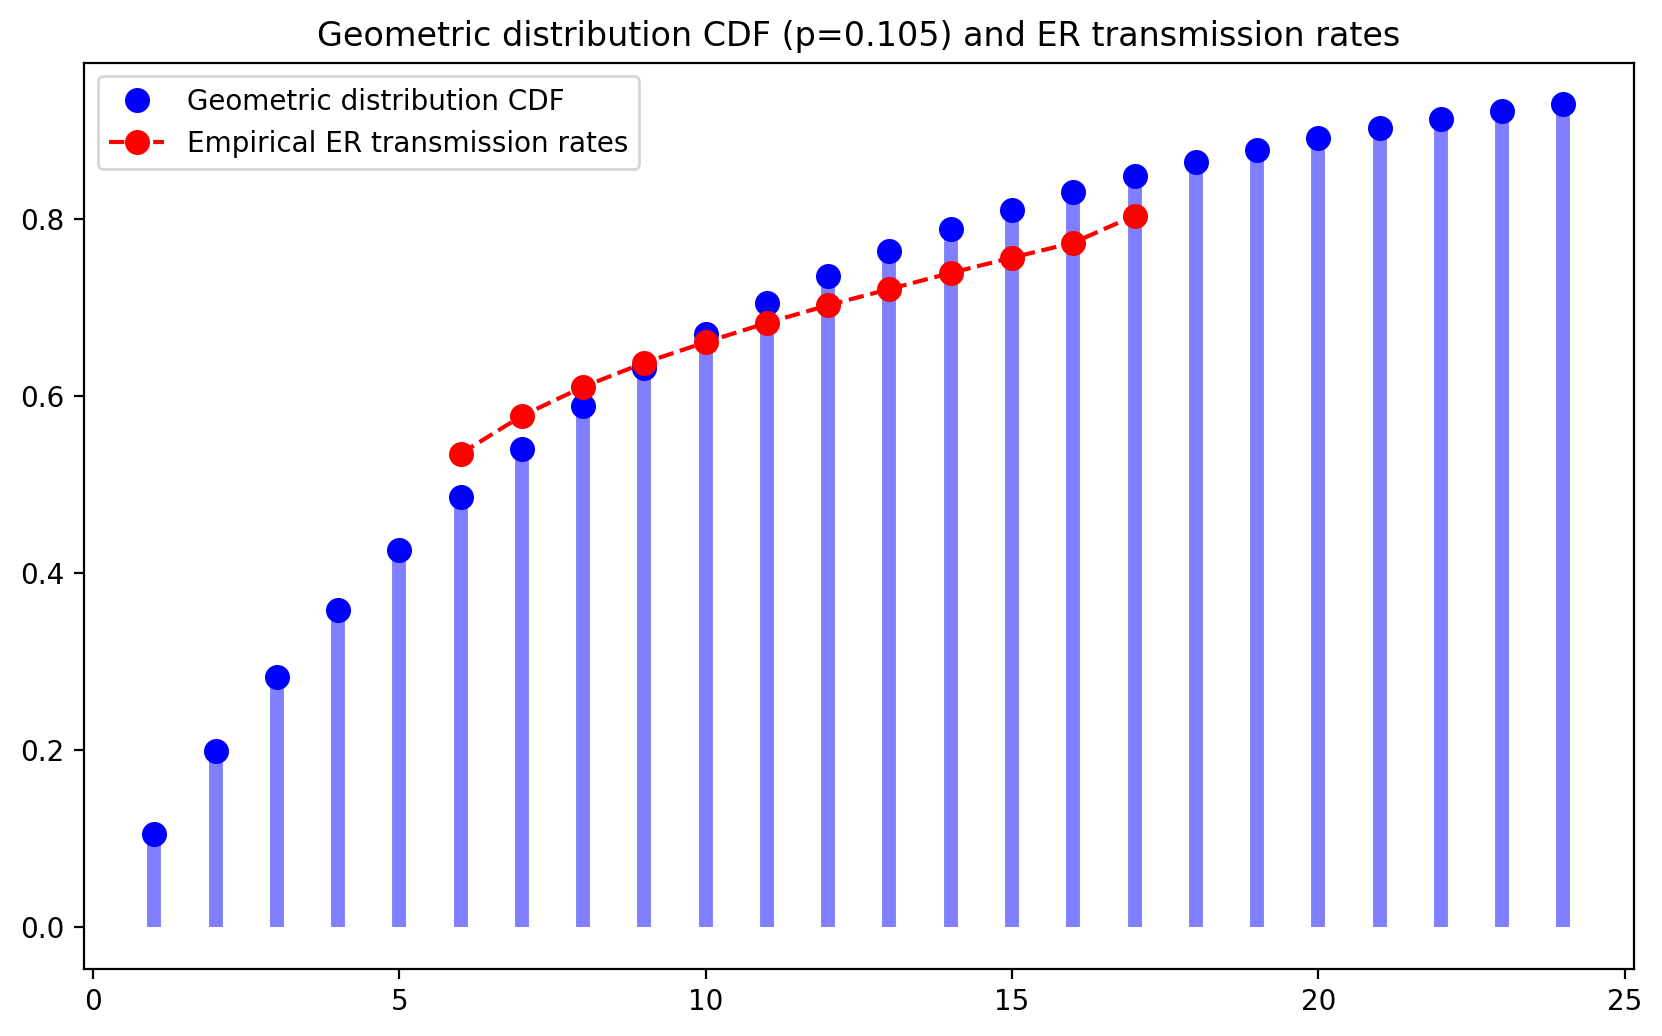

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=200)

PERIODS_PER_HOUR = 4

xi = list(range(1, (6 * PERIODS_PER_HOUR) + 1))

ax.plot(xi, geom.cdf(xi, opt_p), 'bo', ms=8, label='Geometric distribution CDF')
ax.vlines(xi, 0, geom.cdf(xi, opt_p), colors='b', lw=5, alpha=0.5)
er_rates_reindexed.plot(ax=ax, color="r", linestyle="--", marker="o", markersize=8, label="Empirical ER transmission rates")
ax.set_title(f"Geometric distribution CDF (p={opt_p}) and ER transmission rates")
ax.legend()


## Simulate the transmission process

In [10]:
DATA_CACHE = {}

def cache_load_pres_data(path):
    if path not in DATA_CACHE:
        data = json.loads(path.read_text())
        data = pd.DataFrame(data["rs"])

        data = data[data["cc"] == PRES_CODE]
        data = data.merge(data_map_president, on="bo", how="left")

        DATA_CACHE[path] = data

    return DATA_CACHE[path]

The next code block simulates the random receiving of ERs by the COMELEC servers.

Each ER is assumed to successfully transmit to the server in a random process, modeled by a geometric distribution.

In [12]:
rvs = np.random.geometric(opt_p, size=len(results_files))
print(pd.Series(rvs).describe())

fields = ["bo", "v", "tot", "per", "ser", "bon", "pc", "pn"]

batch = {rv: [] for rv in rvs}

for rv, rf in zip(rvs, results_files):

    try:
        pres = cache_load_pres_data(rf)
        batch[rv].append(pres[fields])
    except KeyError:
        print(f"Skipping {rf}")

count    105911.000000
mean          9.538414
std           9.000314
min           1.000000
25%           3.000000
50%           7.000000
75%          13.000000
max         109.000000
dtype: float64
Skipping data/results/154/154811.json


Next, we aggregate the results to represent the empirical data observed in regular periods (~15 minute interval) from COMELEC.

In [13]:
rv_data = []

for rv in sorted(batch.keys()):
    b = pd.concat(batch[rv])
    b = b.groupby("bon")["v"].sum()

    db = dict(
        count=len(batch[rv]),
        hour=rv,
        total=b.sum()
    )
    db.update(b.to_dict())
    rv_data.append(db)

rv_data = pd.DataFrame(rv_data).set_index(["hour", "count"])
rv_data

,,total,"ABELLA, ERNIE (IND)","DE GUZMAN, LEODY (PLM)","DOMAGOSO, ISKO MORENO (AKSYON)","GONZALES, NORBERTO (PDSP)","LACSON, PING (PDR)","MANGONDATO, FAISAL (KTPNAN)","MARCOS, BONGBONG (PFP)","MONTEMAYOR, JOSE JR. (DPP)","PACQUIAO, MANNY PACMAN(PROMDI)","ROBREDO, LENI (IND)"
hour,count,,,,,,,,,,,
1,10934,5450233,11537,9383,199043,9032,91227,27117,3218901,6347,367450,1510196
2,10077,5060055,10601,8788,182526,8320,83644,26732,2982189,5646,339907,1411702
3,8937,4470085,9603,7716,158250,7794,75011,23228,2633682,5018,301504,1248279
4,8035,4004152,8763,7087,140121,6756,66943,21620,2355999,4653,275283,1116927
5,7164,3572423,7668,6395,127871,6098,59066,17321,2096296,3987,250453,997268
...,...,...,...,...,...,...,...,...,...,...,...,...
93,1,412,0,0,2,1,12,0,257,0,17,123
95,1,578,0,2,4,0,2,1,38,0,1,530
97,1,496,4,3,7,3,4,1,138,4,104,228


## Analyse the simulated data

After generating the simulated data, we can verify if the trend that is observed empirically is emergent from the natural random process of the transmission of the ERs from precincts.

In [14]:
sub_data = rv_data[["MARCOS, BONGBONG (PFP)", "ROBREDO, LENI (IND)"]].copy()
sub_data

,,"MARCOS, BONGBONG (PFP)","ROBREDO, LENI (IND)"
hour,count,,
1,10934,3218901,1510196
2,10077,2982189,1411702
3,8937,2633682,1248279
4,8035,2355999,1116927
5,7164,2096296,997268
...,...,...,...
93,1,257,123
95,1,38,530
97,1,138,228


In [15]:
s_nc = sub_data.divide(sub_data.sum(axis=1), axis=0)
s_nc

,,"MARCOS, BONGBONG (PFP)","ROBREDO, LENI (IND)"
hour,count,,
1,10934,0.680659,0.319341
2,10077,0.678713,0.321287
3,8937,0.678441,0.321559
4,8035,0.678390,0.321610
5,7164,0.677631,0.322369
...,...,...,...
93,1,0.676316,0.323684
95,1,0.066901,0.933099
97,1,0.377049,0.622951


Text(0.5, 1.0, 'Share of votes (non-cumulative)')

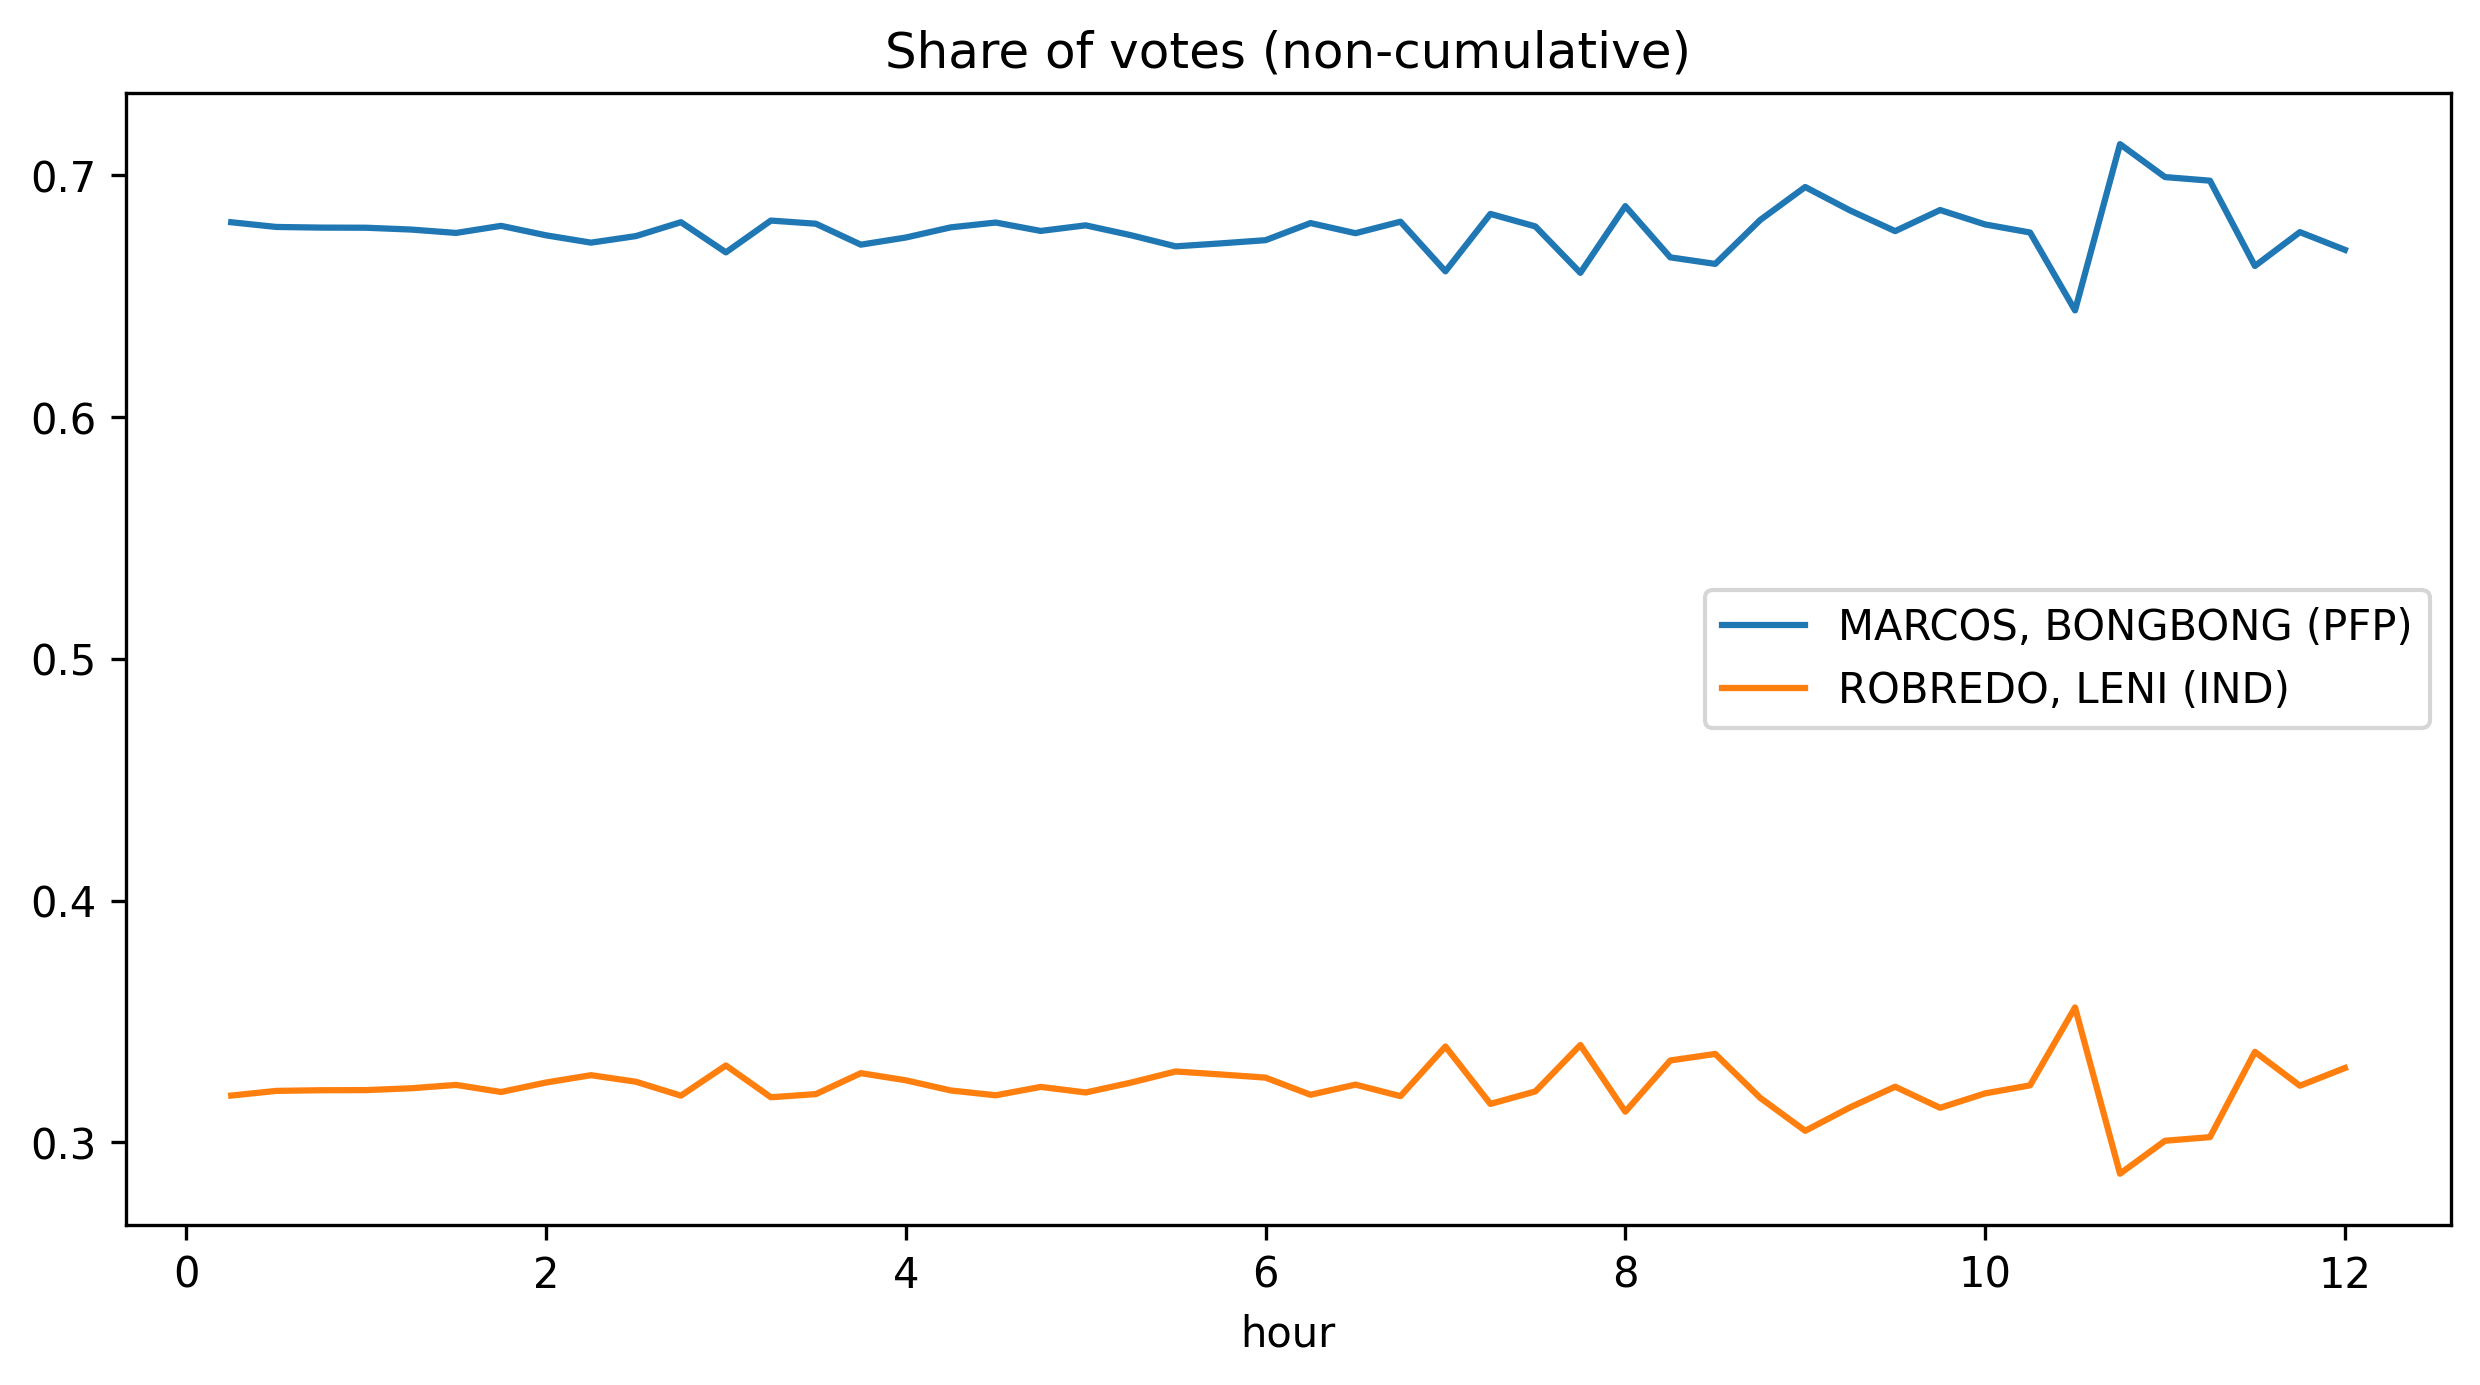

In [18]:
ss = s_nc

ss = ss.reset_index(level=1, drop="count")
ss.index = ss.index / 4

fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.gca()
ss.iloc[:4 * 12].plot(ax=ax)

ax.set_title("Share of votes (non-cumulative)")

In [19]:
s_cu = sub_data.cumsum().divide(sub_data.cumsum().sum(axis=1), axis=0)
s_cu

,,"MARCOS, BONGBONG (PFP)","ROBREDO, LENI (IND)"
hour,count,,
1,10934,0.680659,0.319341
2,10077,0.679721,0.320279
3,8937,0.679339,0.320661
4,8035,0.679139,0.320861
5,7164,0.678901,0.321099
...,...,...,...
93,1,0.677279,0.322721
95,1,0.677271,0.322729
97,1,0.677269,0.322731


Text(0.5, 1.0, 'Share of votes (cumulative)')

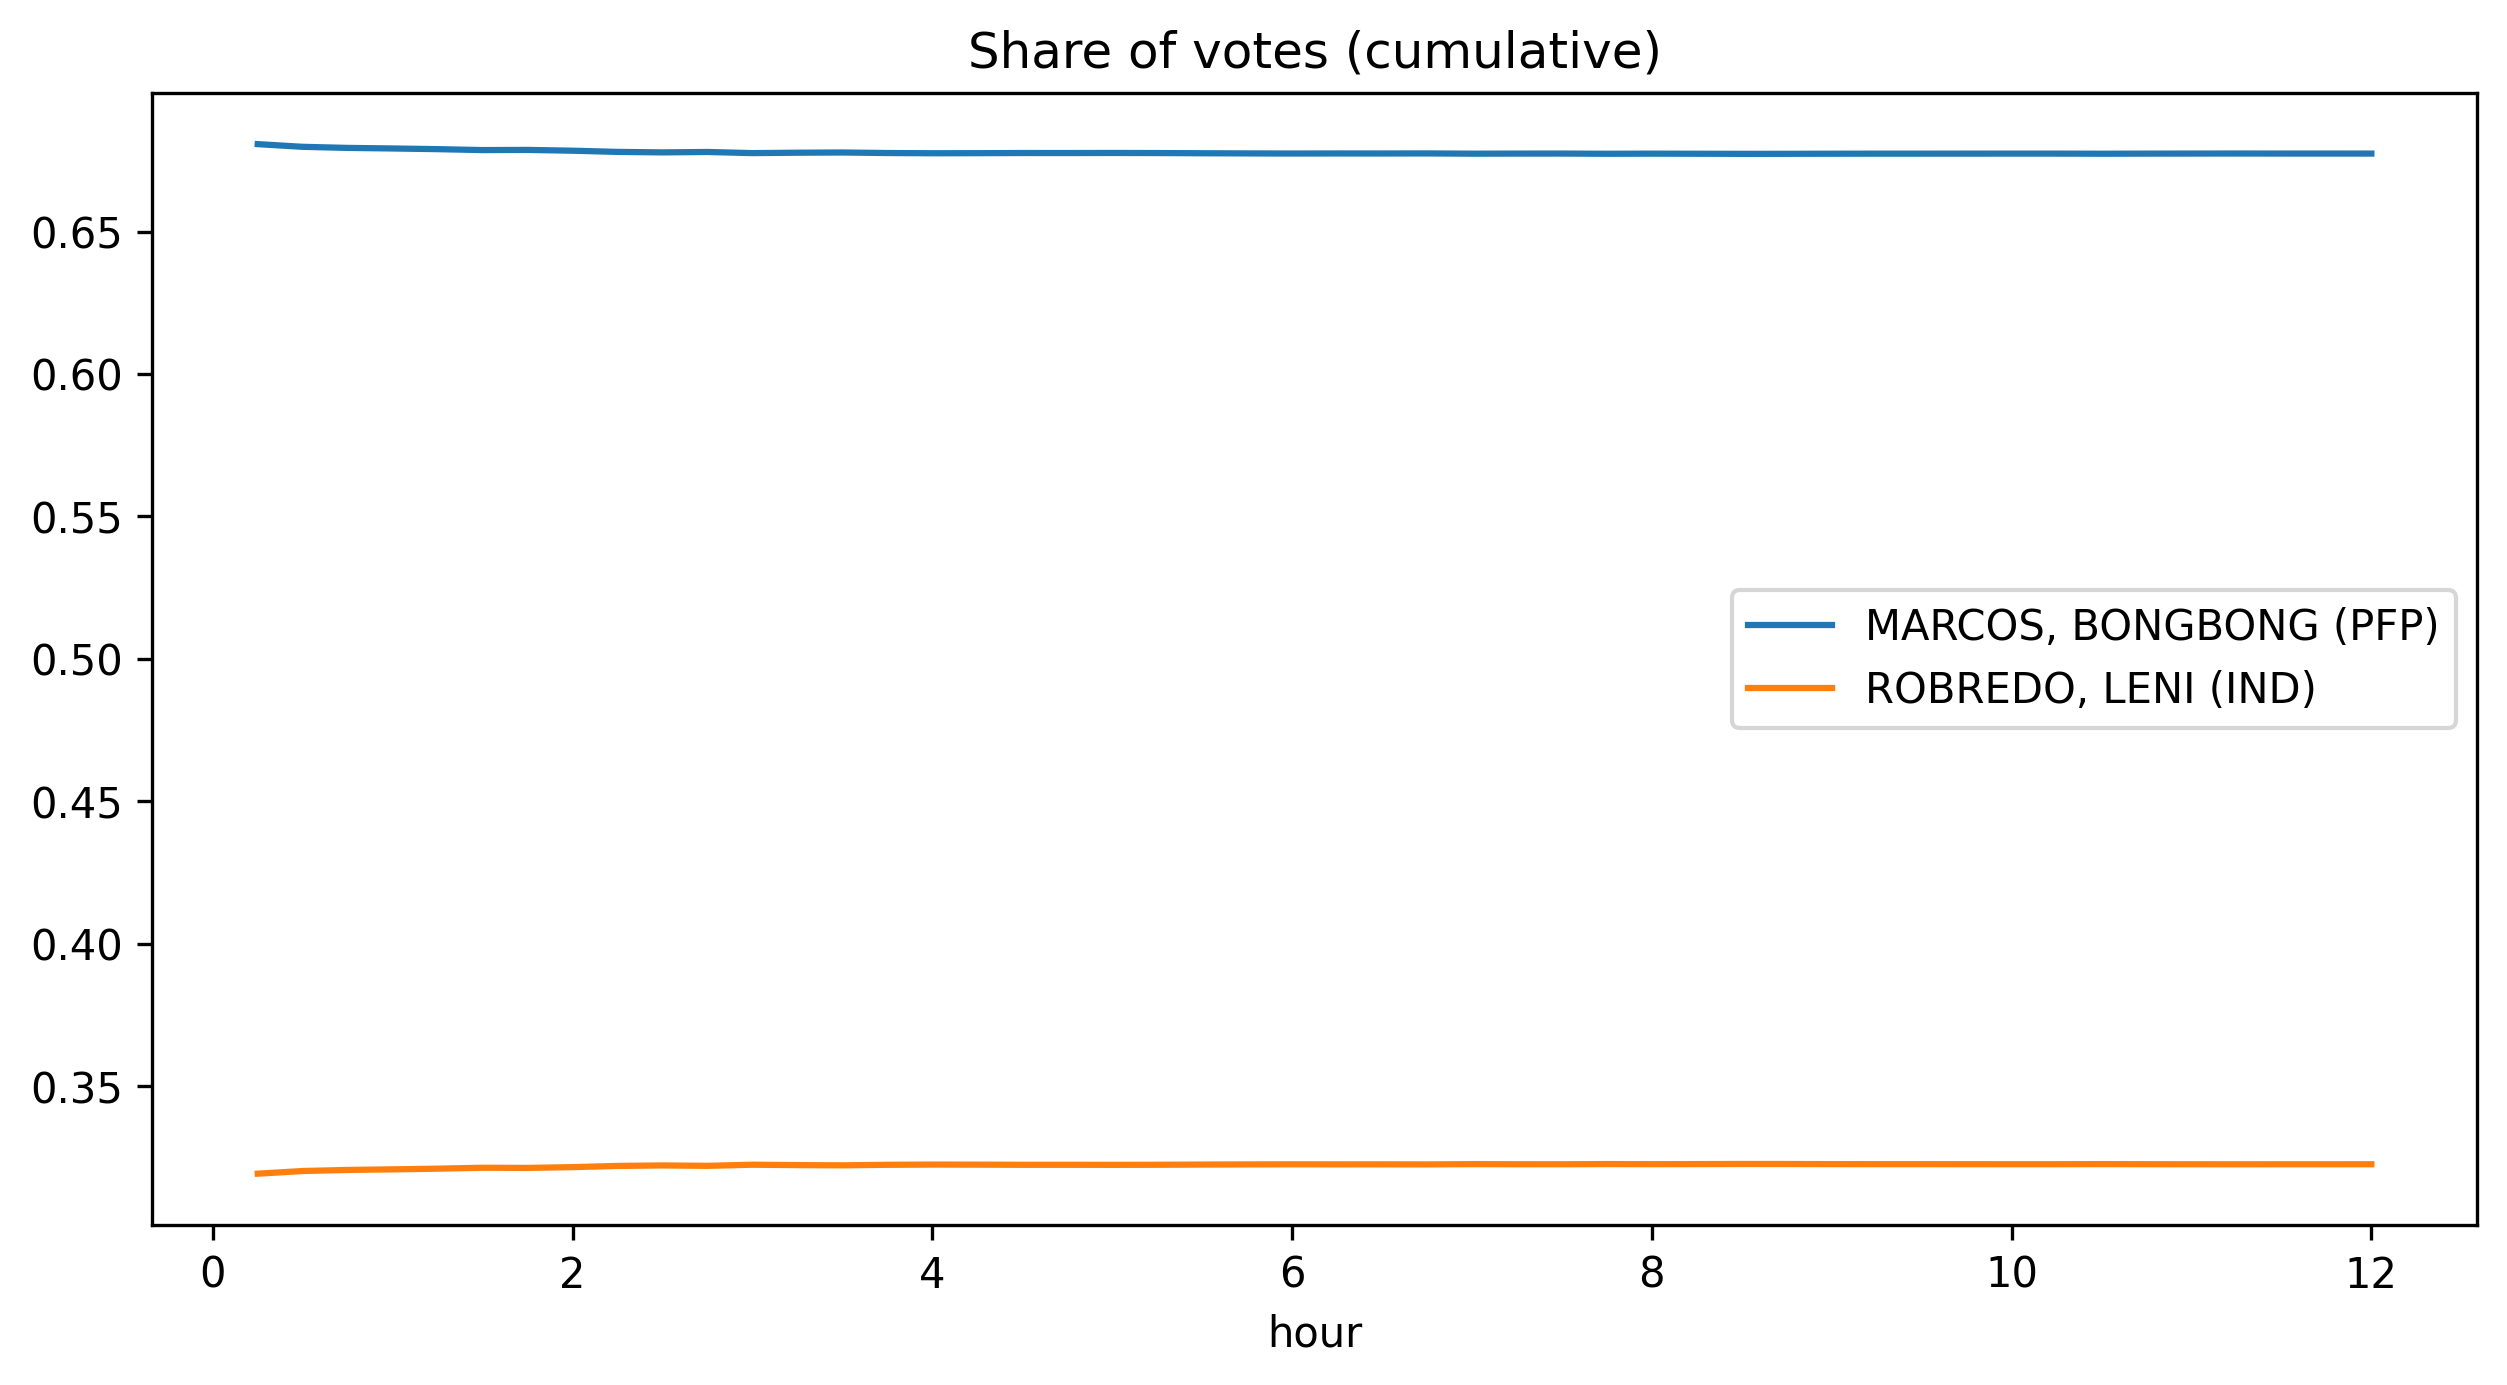

In [20]:
ss = s_cu

ss = ss.reset_index(level=1, drop="count")
ss.index = ss.index / 4

fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.gca()
ss.iloc[:4 * 12].plot(ax=ax)

ax.set_title("Share of votes (cumulative)")

# Generating an ensemble for quantifying the confidence interval

In [22]:
results_files = list(RESULTS_DIR.glob("*/*.json"))
print(f"Total available precincts data: {len(results_files)}")

ensemble_s_cu = []
ensemble_s_nc = []

N = 100

for n in range(1, N + 1):
    if n % 10 == 0:
        print(n)

    rvs = np.random.geometric(opt_p, size=len(results_files))
    # print(pd.Series(rvs).describe())

    fields = ["bo", "v", "tot", "per", "ser", "bon", "pc", "pn"]

    batch = {rv: [] for rv in rvs}

    for rv, rf in zip(rvs, results_files):
        try:
            pres = cache_load_pres_data(rf)
            batch[rv].append(pres[fields])
        except KeyError:
            print(f"Skipping {rf}")

    rv_data = []

    for rv in sorted(batch.keys()):
        b = pd.concat(batch[rv])
        b = b.groupby("bon")["v"].sum()

        db = dict(
            count=len(batch[rv]),
            hour=rv,
            total=b.sum()
        )
        db.update(b.to_dict())
        rv_data.append(db)

    rv_data = pd.DataFrame(rv_data).set_index(["hour", "count"])

    sub_data = rv_data[["MARCOS, BONGBONG (PFP)", "ROBREDO, LENI (IND)"]].copy()

    s_nc = sub_data.divide(sub_data.sum(axis=1), axis=0)
    ensemble_s_nc.append(s_nc)

    s_cu = sub_data.cumsum().divide(sub_data.cumsum().sum(axis=1), axis=0)
    ensemble_s_cu.append(s_cu)
    

Total available precincts data: 105911
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
10
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
20
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipping data/results/154/154811.json
Skipp

Text(0.5, 1.0, 'Share of votes (non-cumulative)')

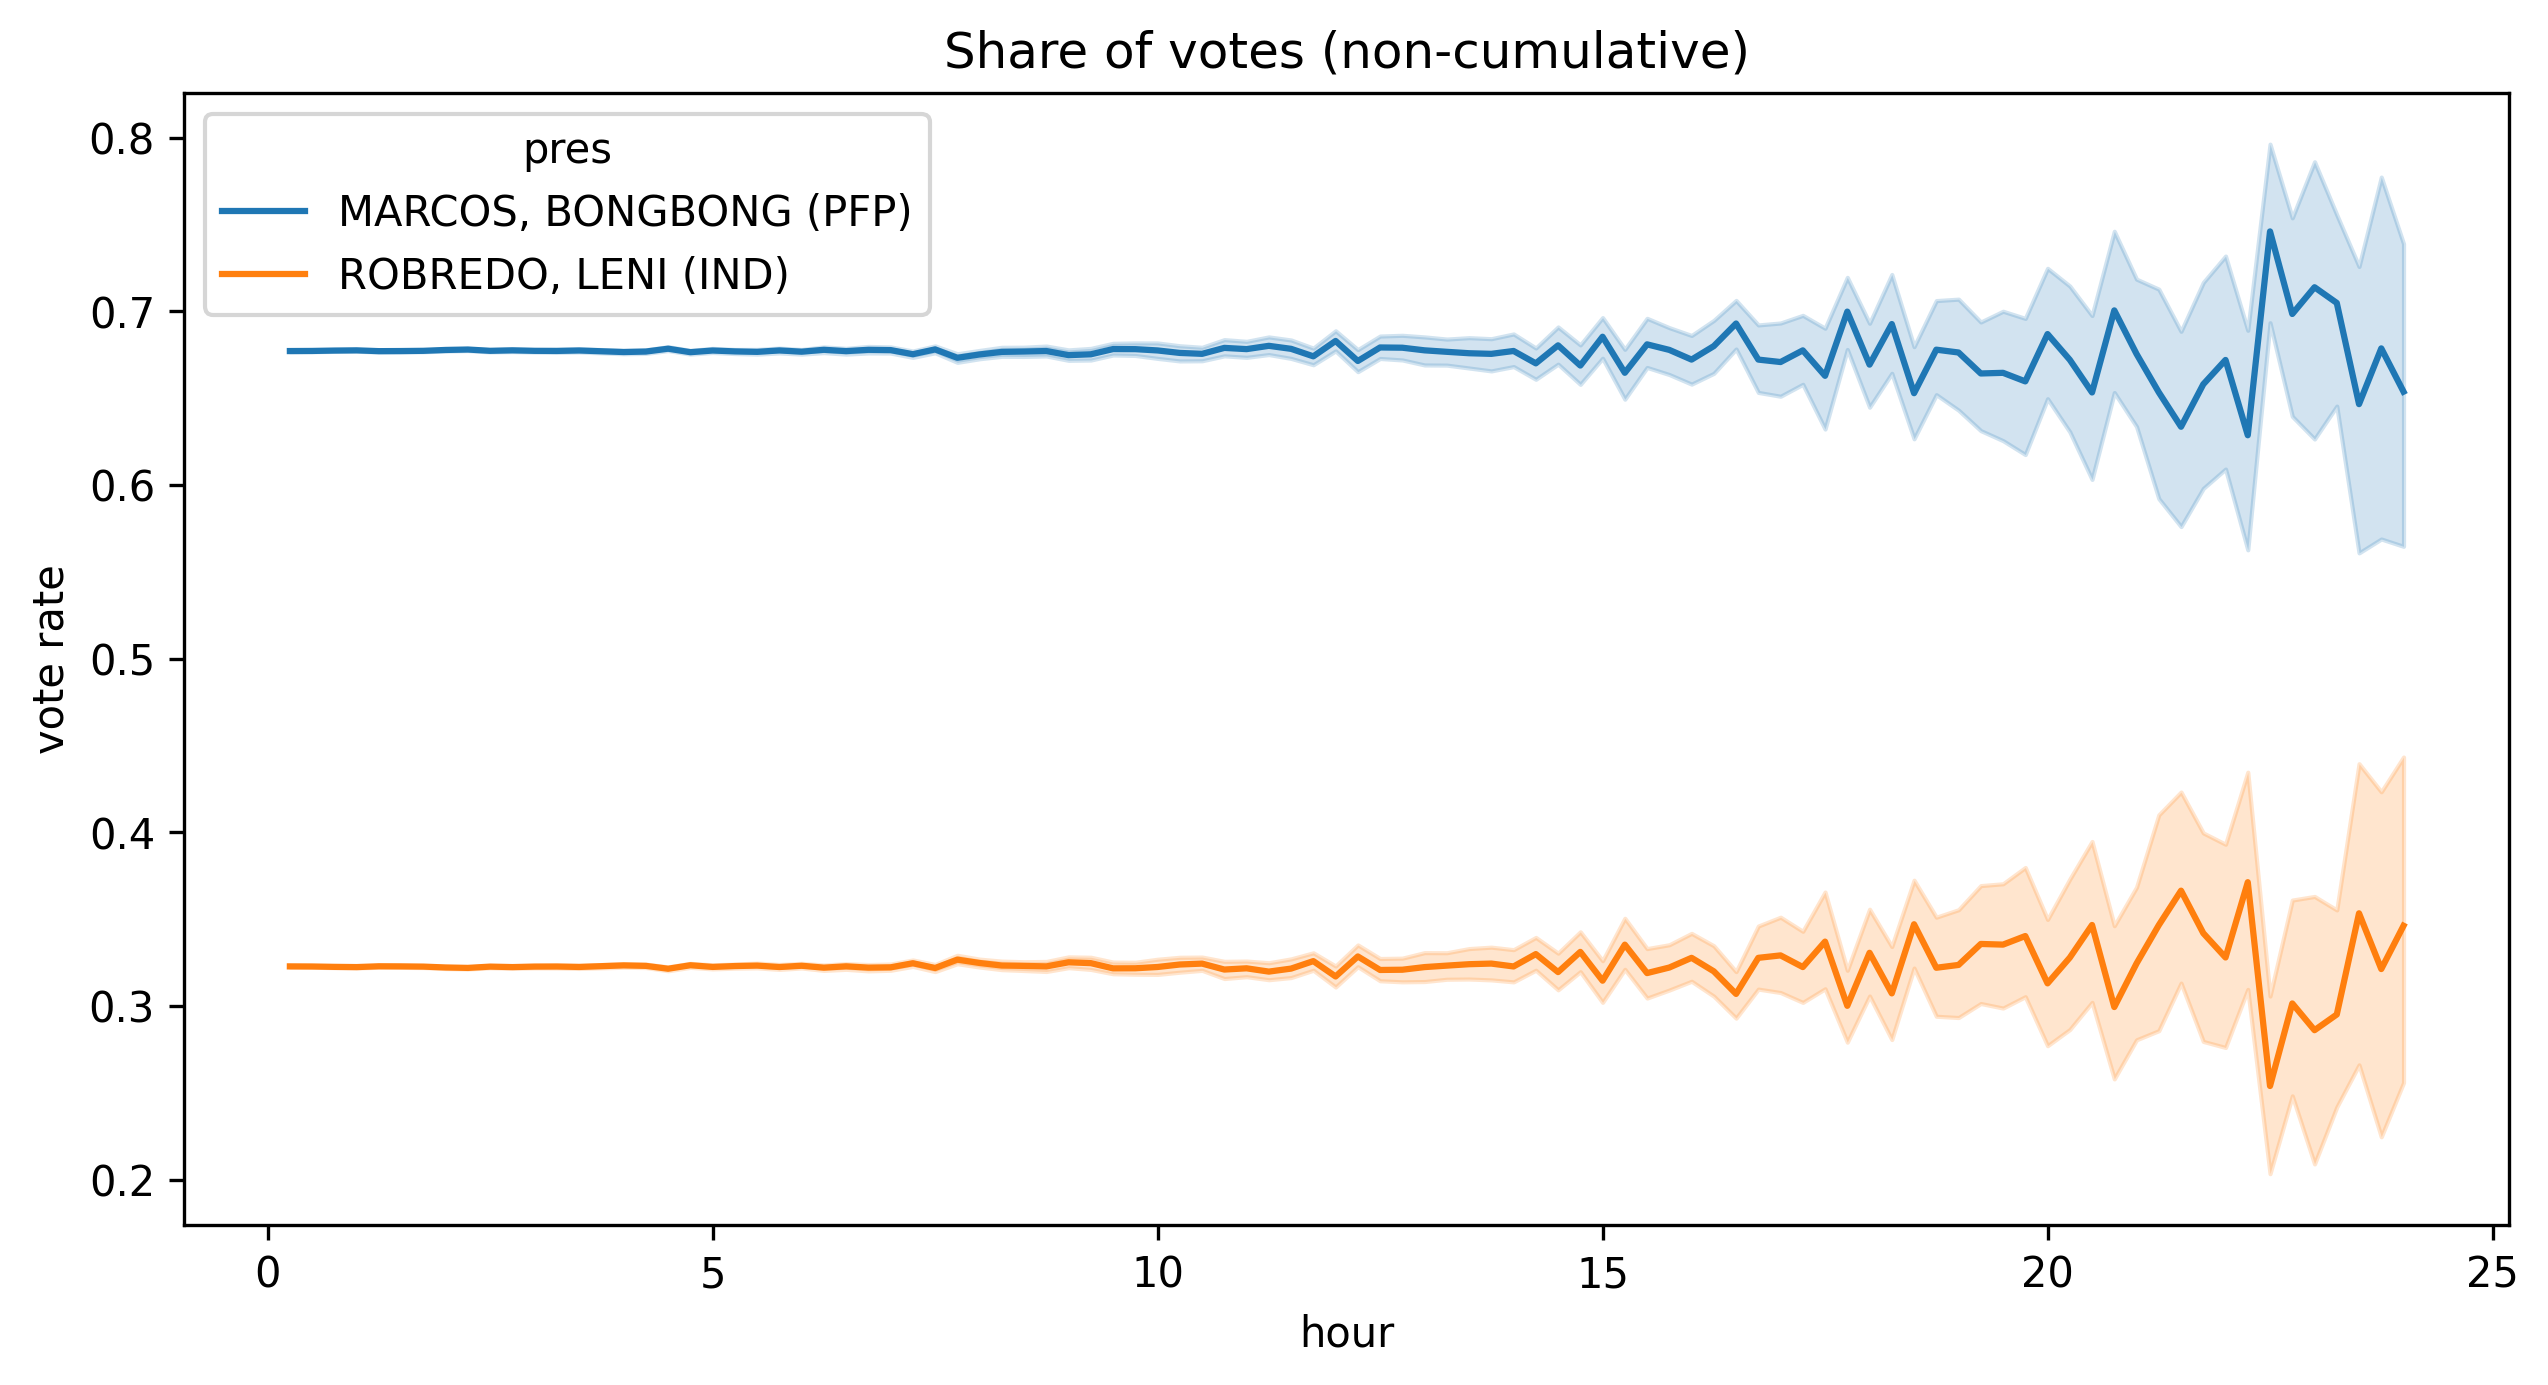

In [23]:
eee = ensemble_s_nc.copy()
eee = pd.concat([e.reset_index(level=1, drop="count").reset_index() for e in eee])

b_eee = pd.DataFrame()
b_eee["hour"] = eee["hour"]
b_eee["vote rate"] = eee["MARCOS, BONGBONG (PFP)"]
b_eee["pres"] = "MARCOS, BONGBONG (PFP)"

l_eee = pd.DataFrame()
l_eee["hour"] = eee["hour"]
l_eee["vote rate"] = eee["ROBREDO, LENI (IND)"]
l_eee["pres"] = "ROBREDO, LENI (IND)"

long_eee = pd.concat([b_eee, l_eee]).reset_index(drop="index")
long_eee["hour"] = long_eee["hour"] / PERIODS_PER_HOUR

fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.gca()

sns.lineplot(data=long_eee[long_eee["hour"] <= 24], x="hour", y="vote rate", hue="pres", ax=ax)
ax.set_title("Share of votes (non-cumulative)")

Text(0.5, 1.0, 'Share of votes (cumulative)')

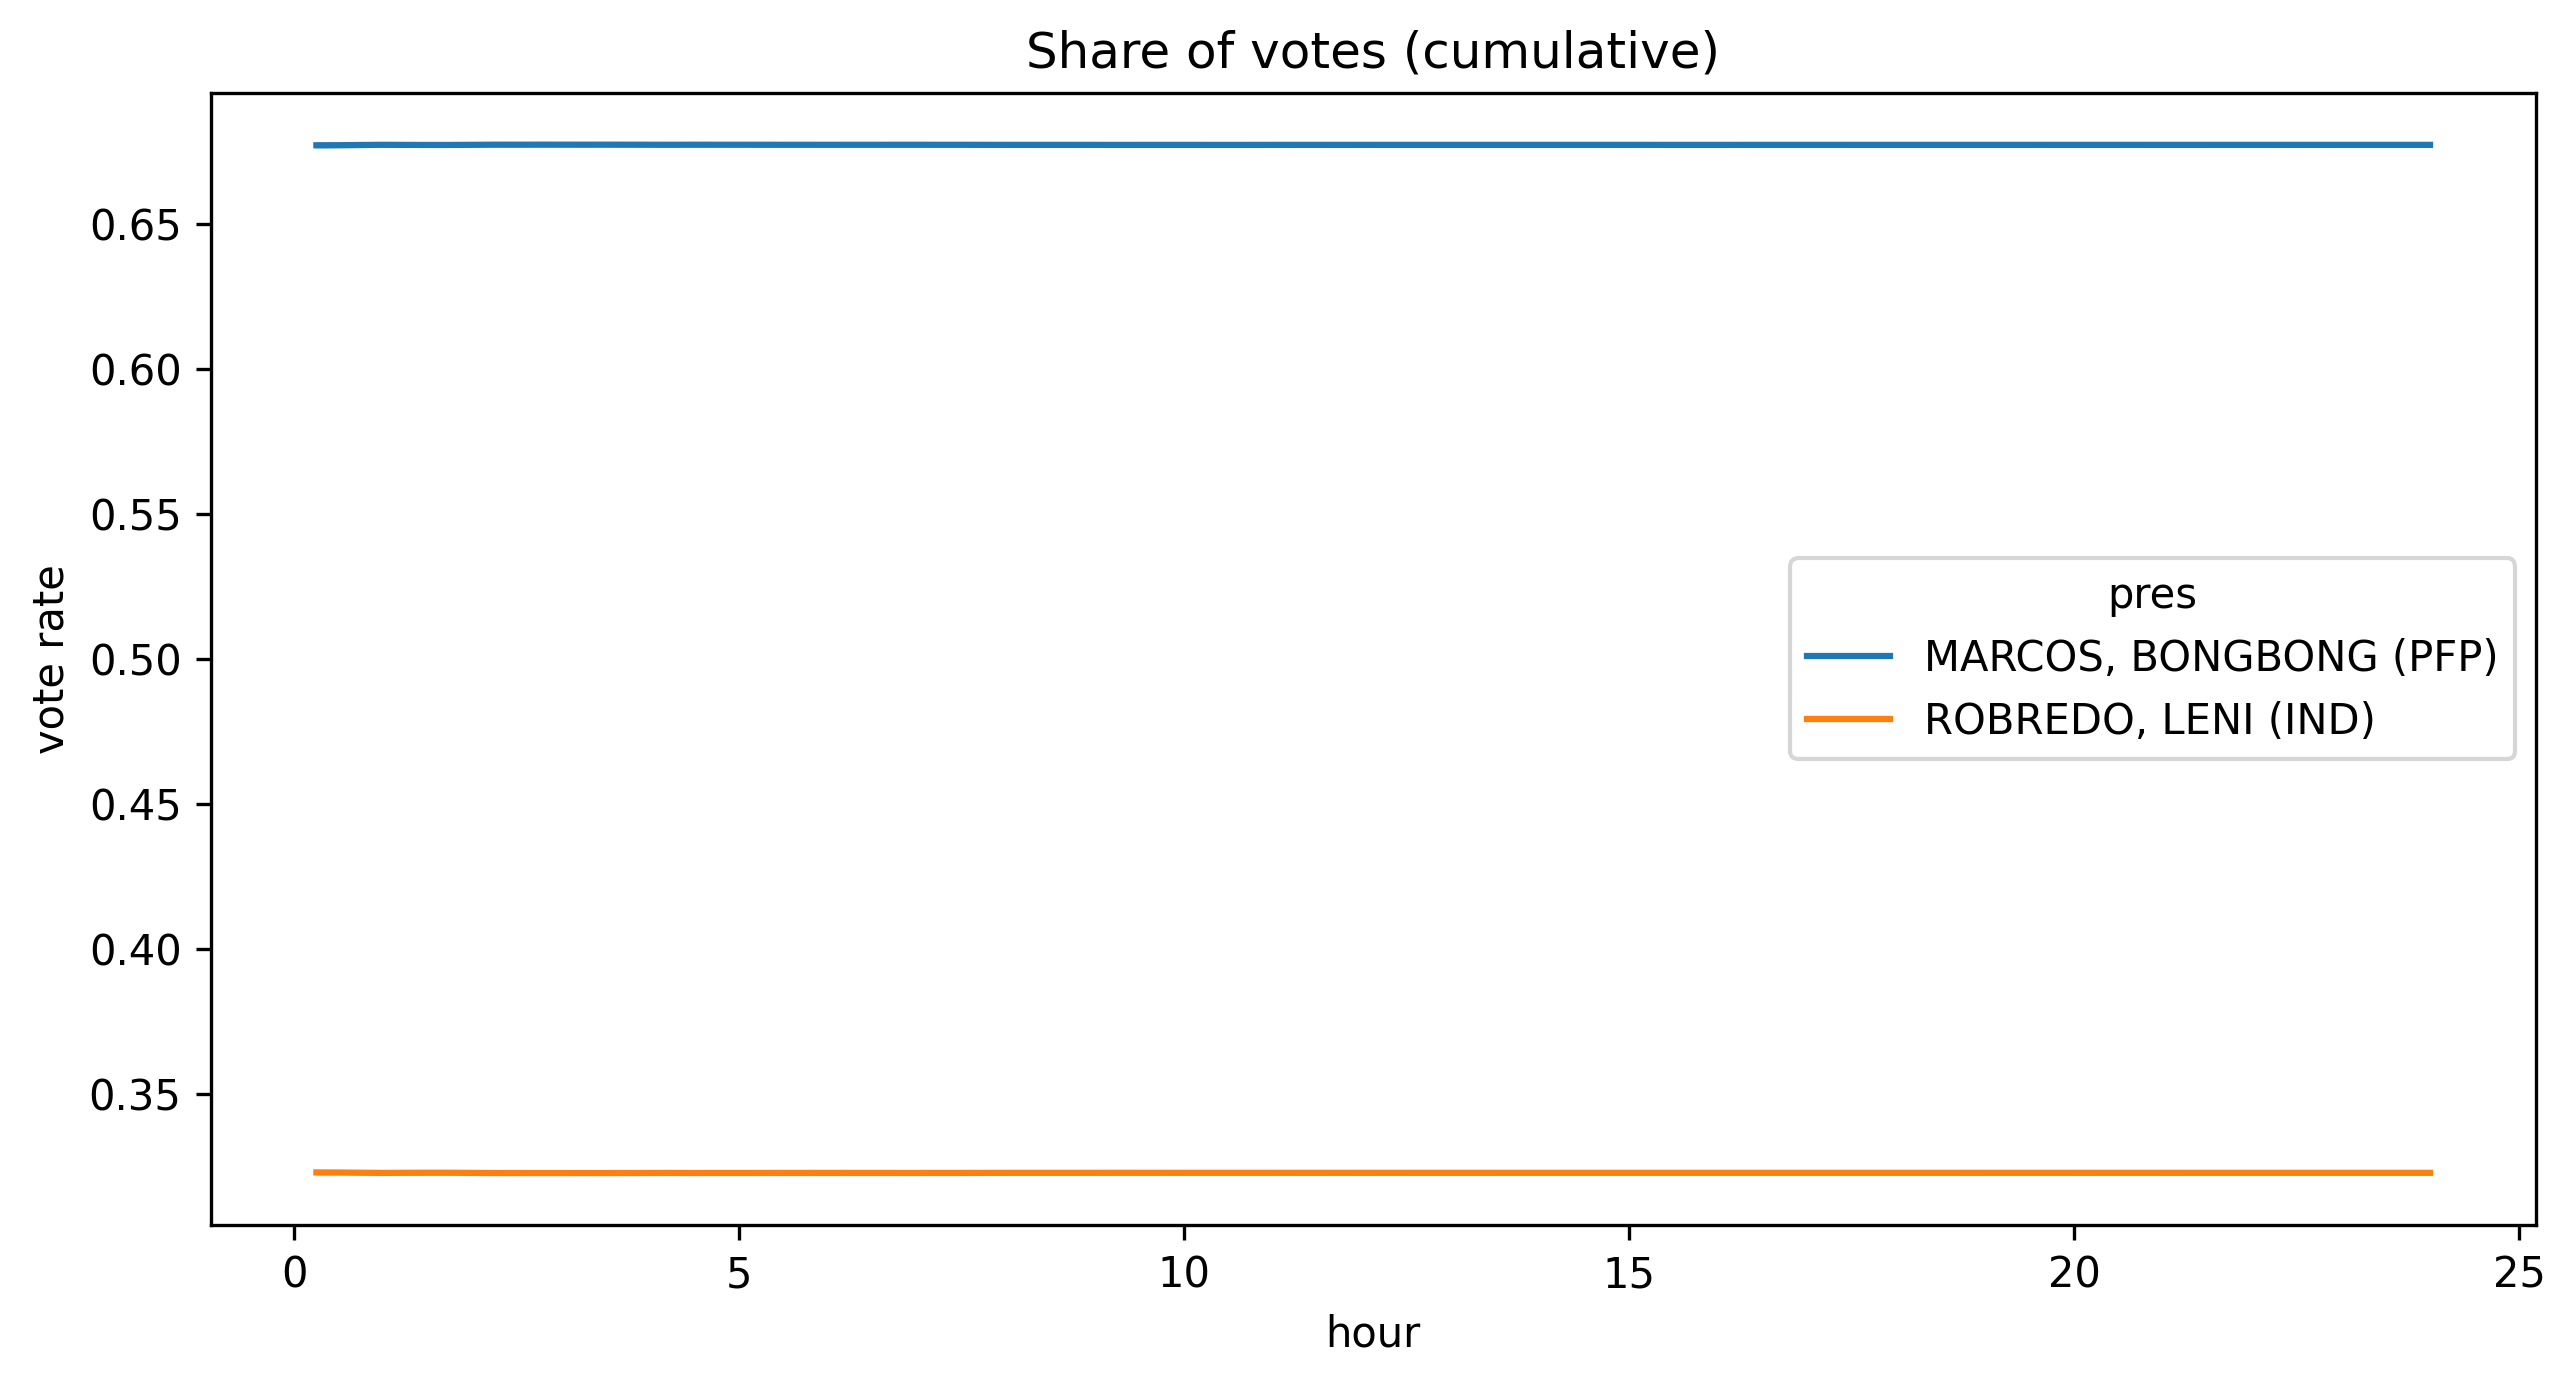

In [24]:
eee = ensemble_s_cu.copy()
eee = pd.concat([e.reset_index(level=1, drop="count").reset_index() for e in eee])

b_eee = pd.DataFrame()
b_eee["hour"] = eee["hour"]
b_eee["vote rate"] = eee["MARCOS, BONGBONG (PFP)"]
b_eee["pres"] = "MARCOS, BONGBONG (PFP)"

l_eee = pd.DataFrame()
l_eee["hour"] = eee["hour"]
l_eee["vote rate"] = eee["ROBREDO, LENI (IND)"]
l_eee["pres"] = "ROBREDO, LENI (IND)"

long_eee = pd.concat([b_eee, l_eee]).reset_index(drop="index")
long_eee["hour"] = long_eee["hour"] / PERIODS_PER_HOUR

fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.gca()

sns.lineplot(data=long_eee[long_eee["hour"] <= 24], x="hour", y="vote rate", hue="pres", ax=ax)
ax.set_title("Share of votes (cumulative)")